In [1]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
import time
from PIL import Image
import datetime
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras.models import Sequential, Model, load_model, model_from_json
from tensorflow.keras.layers import Dense, Conv2D, Input, Convolution2D, ZeroPadding2D, AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D, Flatten, Dropout, Activation, Reshape
from tensorflow.keras.layers import concatenate
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical  
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import SGD, Adam
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix

In [2]:
#/global/scratch/users/cpezov/AAPBO/images/BenchmarkX/file_name.png
#/global/scratch/users/cpezov/AAPBO/labels.txt

x_train_all = []
y_train_all = []
x_test = []
y_test = []

main_path="/global/scratch/users/cpezov/AAPBO/"
d_path = main_path + "datasets-v4/"
i_path = main_path + "images/"

num_class=8 #7 solvers and "No solution"   #v4

#Get each one of the images, in order
#Randomly assign to test/train set, per family
random.seed(9)
with open(d_path+"txt_files/data_ordered.txt") as f:
    lines = f.readlines()
    for l in lines:
        r = random.randint(0,2)
        end = l.rfind(".")
        img_name = i_path + l[2:end] + ".png"
        #print(img_name)
        file_name = d_path + l[2:]
        #print(file_name)
        if(r==2):
            x_test.append(img_to_array(load_img(img_name,color_mode="grayscale")))
        else:
            x_train_all.append(img_to_array(load_img(img_name,color_mode="grayscale")))
        
print("X Train: "+str(len(x_train_all)))
print("X Test: "+str(len(x_test)))

#read labels and transform to one-hot
random.seed(9) #same seed to generate same random numbers as before 
with open(main_path+"labels-v4.txt") as f: #v4
    lines = f.readlines()
    for l in lines:
        r = random.randint(0,2)
        lbls = [int(x) for x in l.split()]
        one_hot = to_categorical(lbls, num_classes=num_class)
        if(r==2):
            y_test.append(one_hot)
        else:
            y_train_all.append(one_hot)
            
print("Y Train: "+str(len(y_train_all)))
print("Y Test: "+str(len(y_test)))
            
#x_train, x_test, y_train, y_test = model_selection.train_test_split (x, y, test_size=1./3.)

x_test = np.array(x_test)
y_test = np.array(y_test)

X Train: 2054
X Test: 1074
Y Train: 2054
Y Test: 1074


In [3]:
#Once separated train/test, the train set must be separated train/validation in 80:20 (4:1) ratio

x_train = []
y_train = []
x_val = []
y_val = []

random.seed(3)
for i in range(len(y_train_all)):
    r = random.randint(0,4)
    if(r==4):
        x_val.append(x_train_all[i])
        y_val.append(y_train_all[i])
    else:
        x_train.append(x_train_all[i])
        y_train.append(y_train_all[i])

x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(1645, 256, 256, 1)
(1645, 500, 8)
(409, 256, 256, 1)
(409, 500, 8)


In [4]:
#Modelo

input_shape = (256,256,1) #resolucion imagen orignal
loss="categorical_crossentropy"
opt = keras.optimizers.Adam(learning_rate = 0.0001,epsilon=1e-08)
#opt = SGD(lr=0.01)


#ALEXNET
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=input_shape),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(500*num_class, activation='softmax'),
    keras.layers.Reshape((500,num_class))
])

model.compile(loss=loss, optimizer=opt, metrics=['acc', 'mse'])      
model.summary() #ver resumen red

# regularizadores
log_dir = main_path+"models/v4/alexNet-v4/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb = TensorBoard(log_dir=log_dir, histogram_freq=1)
mc = ModelCheckpoint(main_path+'models/v4/alexNet-v4/models/model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_acc',mode='max',patience=50, verbose=1)

# fit model
#posiblemente cambiar cant de epochs
alexNet_HISTORY = model.fit(x=x_train, y=y_train, batch_size=128, epochs=1000, validation_data=(x_val,y_val), shuffle=True, verbose = 1,callbacks=[es,mc,tb])  


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 96)        11712     
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 384)       8

13/13 [==============================] - 11s 808ms/step - loss: 0.8571 - acc: 0.6816 - mse: 0.1247 - val_loss: 2.7736 - val_acc: 0.4678 - val_mse: 0.1248
Epoch 15/1000
13/13 [==============================] - ETA: 0s - loss: 0.8274 - acc: 0.6878 - mse: 0.1247
Epoch 00015: val_acc did not improve from 0.46781
13/13 [==============================] - 8s 641ms/step - loss: 0.8274 - acc: 0.6878 - mse: 0.1247 - val_loss: 2.3366 - val_acc: 0.4636 - val_mse: 0.1248
Epoch 16/1000
13/13 [==============================] - ETA: 0s - loss: 0.7817 - acc: 0.7028 - mse: 0.1247
Epoch 00016: val_acc did not improve from 0.46781
13/13 [==============================] - 8s 644ms/step - loss: 0.7817 - acc: 0.7028 - mse: 0.1247 - val_loss: 3.2228 - val_acc: 0.4660 - val_mse: 0.1248
Epoch 17/1000
13/13 [==============================] - ETA: 0s - loss: 0.7637 - acc: 0.7105 - mse: 0.1247
Epoch 00017: val_acc did not improve from 0.46781
13/13 [==============================] - 8s 645ms/step - loss: 0.7637 - 

13/13 [==============================] - 8s 644ms/step - loss: 0.2296 - acc: 0.9139 - mse: 0.1245 - val_loss: 1.9989 - val_acc: 0.5150 - val_mse: 0.1248
Epoch 64/1000
13/13 [==============================] - ETA: 0s - loss: 0.2237 - acc: 0.9167 - mse: 0.1245
Epoch 00064: val_acc did not improve from 0.54674
13/13 [==============================] - 8s 643ms/step - loss: 0.2237 - acc: 0.9167 - mse: 0.1245 - val_loss: 2.2628 - val_acc: 0.5007 - val_mse: 0.1248
Epoch 65/1000
13/13 [==============================] - ETA: 0s - loss: 0.2217 - acc: 0.9174 - mse: 0.1245
Epoch 00065: val_acc did not improve from 0.54674
13/13 [==============================] - 8s 641ms/step - loss: 0.2217 - acc: 0.9174 - mse: 0.1245 - val_loss: 4.2791 - val_acc: 0.4220 - val_mse: 0.1248
Epoch 66/1000
13/13 [==============================] - ETA: 0s - loss: 0.2238 - acc: 0.9179 - mse: 0.1245
Epoch 00066: val_acc did not improve from 0.54674
13/13 [==============================] - 8s 644ms/step - loss: 0.2238 - a

13/13 [==============================] - 8s 644ms/step - loss: 0.1798 - acc: 0.9328 - mse: 0.1245 - val_loss: 2.4723 - val_acc: 0.5025 - val_mse: 0.1248
Epoch 90/1000
13/13 [==============================] - ETA: 0s - loss: 0.1773 - acc: 0.9321 - mse: 0.1245
Epoch 00090: val_acc did not improve from 0.55690
13/13 [==============================] - 8s 645ms/step - loss: 0.1773 - acc: 0.9321 - mse: 0.1245 - val_loss: 2.2348 - val_acc: 0.5236 - val_mse: 0.1248
Epoch 91/1000
13/13 [==============================] - ETA: 0s - loss: 0.1770 - acc: 0.9330 - mse: 0.1245
Epoch 00091: val_acc did not improve from 0.55690
13/13 [==============================] - 8s 639ms/step - loss: 0.1770 - acc: 0.9330 - mse: 0.1245 - val_loss: 3.3908 - val_acc: 0.5463 - val_mse: 0.1247
Epoch 92/1000
13/13 [==============================] - ETA: 0s - loss: 0.1710 - acc: 0.9332 - mse: 0.1245
Epoch 00092: val_acc did not improve from 0.55690
13/13 [==============================] - 8s 646ms/step - loss: 0.1710 - a

Epoch 116/1000
13/13 [==============================] - ETA: 0s - loss: 0.1476 - acc: 0.9410 - mse: 0.1245
Epoch 00116: val_acc did not improve from 0.55690
13/13 [==============================] - 8s 644ms/step - loss: 0.1476 - acc: 0.9410 - mse: 0.1245 - val_loss: 2.2668 - val_acc: 0.5532 - val_mse: 0.1247
Epoch 117/1000
13/13 [==============================] - ETA: 0s - loss: 0.1476 - acc: 0.9429 - mse: 0.1245
Epoch 00117: val_acc did not improve from 0.55690
13/13 [==============================] - 8s 646ms/step - loss: 0.1476 - acc: 0.9429 - mse: 0.1245 - val_loss: 1.8166 - val_acc: 0.5134 - val_mse: 0.1248
Epoch 118/1000
13/13 [==============================] - ETA: 0s - loss: 0.1595 - acc: 0.9392 - mse: 0.1245
Epoch 00118: val_acc did not improve from 0.55690
13/13 [==============================] - 8s 643ms/step - loss: 0.1595 - acc: 0.9392 - mse: 0.1245 - val_loss: 2.4337 - val_acc: 0.5205 - val_mse: 0.1248
Epoch 119/1000
13/13 [==============================] - ETA: 0s - loss

13/13 [==============================] - 8s 645ms/step - loss: 0.1264 - acc: 0.9503 - mse: 0.1245 - val_loss: 3.5873 - val_acc: 0.5355 - val_mse: 0.1247
Epoch 169/1000
13/13 [==============================] - ETA: 0s - loss: 0.1221 - acc: 0.9533 - mse: 0.1245
Epoch 00169: val_acc did not improve from 0.56084
13/13 [==============================] - 8s 646ms/step - loss: 0.1221 - acc: 0.9533 - mse: 0.1245 - val_loss: 2.9366 - val_acc: 0.5094 - val_mse: 0.1247
Epoch 170/1000
13/13 [==============================] - ETA: 0s - loss: 0.1254 - acc: 0.9502 - mse: 0.1245
Epoch 00170: val_acc did not improve from 0.56084
13/13 [==============================] - 8s 646ms/step - loss: 0.1254 - acc: 0.9502 - mse: 0.1245 - val_loss: 2.3826 - val_acc: 0.5406 - val_mse: 0.1247
Epoch 171/1000
13/13 [==============================] - ETA: 0s - loss: 0.1191 - acc: 0.9535 - mse: 0.1245
Epoch 00171: val_acc did not improve from 0.56084
13/13 [==============================] - 8s 646ms/step - loss: 0.1191 

In [5]:
#Save info
model_json = model.to_json()
with open(main_path+"models/v4/alexNet-v4/models/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(main_path+"models/v4/alexNet-v4/models/model.h5")
print("Saved model to disk")

f = open(main_path+"models/v4/alexNet-v4/results/y_test.txt", "w")
np.savetxt(f,y_test.reshape(y_test.shape[0], -1))
f.close()

f = open(main_path+"models/v4/alexNet-v4/results/y_train.txt", "w")
np.savetxt(f,y_train.reshape(y_train.shape[0], -1))
f.close()

y_pred_onehot = model.predict(x_test, verbose=1)
f = open(main_path+"models/v4/alexNet-v4/results/y_preds_onehot.txt", "w")
np.savetxt(f,y_pred_onehot.reshape(y_pred_onehot.shape[0], -1))
f.close()

y_pred = np.argmax(y_pred_onehot, axis=2)
f = open(main_path+"models/v4/alexNet-v4/results/y_preds.txt", "w")
np.savetxt(f,y_pred.reshape(y_pred.shape[0], -1))
f.close()

Saved model to disk
34/34 [==============================] - 1s 39ms/step


34/34 [==============================] - 1s 34ms/step - loss: 2.1899 - acc: 0.5776 - mse: 0.1247
MODEL Metric names:  ['loss', 'acc', 'mse']
loss: 2.1899328231811523
accuracy: 0.5775847434997559
mse: 0.12471990287303925
HISTORY Keys:  dict_keys(['loss', 'acc', 'mse', 'val_loss', 'val_acc', 'val_mse'])


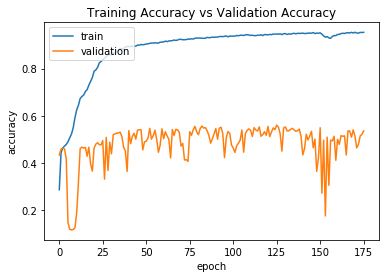

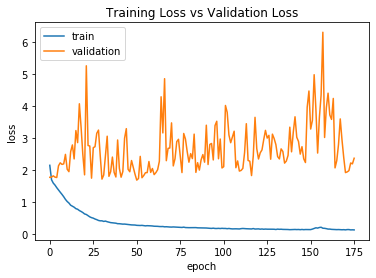

<Figure size 432x288 with 0 Axes>

In [6]:
#Graficos
'''
#Matriz de confusion
lab = [x for x in range(0,num_class)]
matrix = multilabel_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), labels = lab)
print(matrix)

import seaborn as sns

ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax); #annot=True to annotate cells
plt.savefig(fname = "/global/scratch/users/cpezov/AAPBO/models/v4/alexNet-v4/results/confMat.png")
'''
#model.load_weights("/global/scratch/users/cpezov/AAPBO/models/v4/alexNet-v4/models/model.h5") #cargalo de tu ruta
score = model.evaluate(x_test, y_test,verbose=1)
print("MODEL Metric names: ", model.metrics_names)
print("loss:", score[0])
print("accuracy:", score[1])
print("mse:", score[2])

print("HISTORY Keys: ", alexNet_HISTORY.history.keys())
plt.figure(0)
plt.plot(alexNet_HISTORY.history['acc'])
plt.plot(alexNet_HISTORY.history['val_acc'])
plt.title("Training Accuracy vs Validation Accuracy") 
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(main_path+'models/v4/alexNet-v4/results/acc_graph.png')

# summarize history for loss
plt.figure(1)
plt.plot(alexNet_HISTORY.history['loss'])
plt.plot(alexNet_HISTORY.history['val_loss'])
plt.title("Training Loss vs Validation Loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.savefig(main_path+'models/v4/alexNet-v4/results/loss_graph.png')

# Prediction Time

In [4]:
#Load model

# load json and create model
json_file = open(main_path+"models/v4/alexNet-v4/models/model.json", 'r')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)

# load weights into new model
model.load_weights(main_path+"models/v4/alexNet-v4/models/model.h5")
print("Loaded model from disk")

loss="categorical_crossentropy"
opt = keras.optimizers.Adam(learning_rate = 0.0001,epsilon=1e-08)

model.compile(loss=loss, optimizer=opt, metrics=['acc', 'mse'])      
model.summary() #ver resumen red

Loaded model from disk
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 96)        11712     
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (Non

In [5]:
#Verify model has same metrics

y_pred_onehot = model.predict(x_test, verbose=1)
y_pred = np.argmax(y_pred_onehot, axis=2)

score = model.evaluate(x_test, y_test,verbose=1)
print("MODEL Metric names: ", model.metrics_names)
print("loss:", score[0])
print("accuracy:", score[1])
print("mse:", score[2])

34/34 [==============================] - 3s 84ms/step - loss: 2.1899 - acc: 0.5776 - mse: 0.1247
MODEL Metric names:  ['loss', 'acc', 'mse']
loss: 2.1899452209472656
accuracy: 0.5776275396347046
mse: 0.12471991032361984


In [6]:
#Calcular tiempos de predicción por cada par instancia-tiempo de test
#(Correr esto se demora 1 hora aprox)

now=datetime.datetime.now()
print(now)

l=int(len(y_pred))
t_preds=np.empty(l*500) #Una predicción da los resultados de todos los 500 timesteps

#prediccion
for i in range(len(x_test)):
    #crear np.array de solo esa instancia-timestep
    x_i = [x_test[i]]
    x_i = np.array(x_i)
    
    #hacer predicción y medir tiempo
    start=time.time()
    y_i = model.predict(x_i)
    tiempo=time.time()-start
    #Por cada instancia, guardar el mismo tiempo de predicción para los 500 timesteps (para obtener el resultado de 1 timestep, el modelo debe obtener la predicción para todos los timesteps, por lo que el tiempo que toma es el mismo para todos los timesteps)
    for j in range(500): 
        t_preds[500*i+j]=tiempo

2024-03-05 18:04:40.635895


In [7]:
#Guardar tiempos de prediccion

print(t_preds)
f = open(main_path+"models/results-v4/pred_times/t_pred_alexNet-v4.txt", "w")
np.savetxt(f, t_preds, delimiter=" ", fmt="%s")
f.close()

[0.10281348 0.10281348 0.10281348 ... 0.07706666 0.07706666 0.07706666]


In [8]:
now=datetime.datetime.now()
print(now)

2024-03-05 18:06:11.274843
